# RAG Pipeline Evaluation
- Create LLM generated set of Q&A about a document.
- Use LLM critique/quality control these Q&A pairs.
- Run another LLM on the pipeline with these Q&A pairs and study output to validate.

In [1]:
!pip install -q torch transformers transformers langchain sentence-transformers tqdm openpyxl pandas datasets langchain-community ragatouille langchain-huggingface

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 whic

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from tqdm.auto import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import json
import datasets
import os
import re
import torch

In [ ]:

#HF_TOKEN = <secret key>
#OPENAI_API_KEY = <secret key>

In [4]:
from huggingface_hub import login
#notebook_login()
login(token=HF_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Sample Data for Evaluating RAG
- Import and preprocess a document

In [5]:
from langchain.document_loaders import PyPDFLoader, UnstructuredMarkdownLoader, UnstructuredHTMLLoader  # Assumes both loaders exist
#from langchain.docstore.document import Document
from langchain.schema import Document

# Function to write outputs to file
def write_output_to_file(output, filename):
    # Ensure the output directory exists
    out_dir = "/kaggle/working/"
    #os.makedirs(out_dir, exist_ok=True)

    # Define the full file path
    file_path = os.path.join(out_dir, filename)
    
    # Write the output to the file
    with open(file_path, "w") as file:
        file.write(str(output))

# Function to clean text (to remove unwanted line breaks within sentences)
def clean_text(text):
    return re.sub(r'(?<!\n)\n(?!\n)', ' ', text)

# Function to load documents based on file type
def load_documents(file_path):
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() == '.pdf':
        loader = PyPDFLoader(file_path)
        print("Loading PDF document...")
    elif file_extension.lower() == '.md':
        loader = UnstructuredMarkdownLoader(file_path)
        print("Loading Markdown document...")
    elif file_extension.lower() == '.html':
        loader = UnstructuredHTMLLoader(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a PDF or Markdown file.")
    
    documents = loader.load()
    cleaned_documents = [Document(page_content=clean_text(doc.page_content)) for doc in documents]
    return documents

In [6]:
# Load the document and questions
file_path = "/kaggle/input/course-bot-data/bain_syllabus.pdf"  # Change this to the path of your PDF or Markdown file
documents = load_documents(file_path)

Loading PDF document...


In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Set some params
CHUNK_SIZE = 2000
CHUNK_OVERLAP = 200

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
split_docs = text_splitter.split_documents(documents)

# Add to list for later use
docs_processed = []
for doc in documents:
    docs_processed += text_splitter.split_documents([doc])

# Write the chunks to file for manual study
docs = []
for i, doc in enumerate(split_docs):
    output_str = f"Chunk {i + 1}:\n{doc.page_content}\n"
    docs.append(output_str)

write_output_to_file('\n'.join(docs), 'chunks.txt')

### Create Dataset of Q&A Pairs
- Build synthetic dataset for testing the RAG pipeline
- Mistral good for this see https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1

In [17]:
# Define LLM to generate synthetic Q&A pairs
from huggingface_hub import InferenceClient

qa_creation_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"
llm_client = InferenceClient(model=qa_creation_model, timeout=120,)

def call_llm(inference_client: InferenceClient, prompt: str):
    response = inference_client.post(
        json={"inputs": prompt, "parameters": {"max_new_tokens": 1000},"task": "text-generation",},
    )
    return json.loads(response.decode())[0]["generated_text"]

Below, we write a "factoid" question prompt (see https://www-cs-faculty.stanford.edu/people/mengqiu/publication/LSII-LitReview.pdf) to generate synthetic data. Such questions ask for a specific fact type answer that is concise. Straightforward task for LLM and reasonable for syllabus over reasoning/advanced analysis.

In [18]:
qa_creation_prompt = """
### Instructions
Your task is to generate a factoid question and its corresponding answer based on the provided context below.
The factoid question should
1. Be answerable with a specific, concise piece of factual information from the context.
2. Be written in a natural, user-friendly style, similar to what users might input in a search engine.
3. Avoid mentioning terms like "context," "passage," or "according to the text."

The answer to the factoid questions should
1. Be short, precise, and derived directly from the context.
2. Avoid adding any information that is not explicitly present in the context.

### Formatting
Provide your response exactly as follows:

Output:::
Factoid question: (insert your factoid question here)
Answer: (insert your answer to the factoid question here)

### Provided Context
Below is the context upon which to base the factoid question and its corresponding answer

Context: {context}\n
Output:::"""

In [20]:
import random
import time
N_GENERATIONS = 3  # We intentionally generate only 10 QA couples here for cost and time considerations

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
for sampled_context in tqdm(random.sample(docs_processed, N_GENERATIONS)):
    # Generate QA couple
    time.sleep(1)
    output_QA_couple = call_llm(llm_client, qa_creation_prompt.format(context=sampled_context.page_content))
    try:
        question = output_QA_couple.split("Factoid question: ")[-1].split("Answer: ")[0]
        answer = output_QA_couple.split("Answer: ")[-1]
        assert len(answer) < 300, "Answer is too long"
        outputs.append(
            {
                "context": sampled_context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": sampled_context.metadata["source"],
            }
        )
    except:
        continue

Generating 3 QA couples...


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
# Save outputs to readable csv file so we can read manually
outputs_df = pd.DataFrame(outputs)
outputs_df.to_csv('generated_qa.csv', index=False)

In [25]:
# Test one of the questions
print(f'Question: {outputs_df.iloc[0,:].question}')
print(f'Answer: {outputs_df.iloc[0,:].answer}')

Question: What is the primary textbook for the course?

Answer: The primary textbook for the course is Physics: Principles with Applications, 7th edition, by Douglas C. Giancoli.


### Build Critique Models
- Establish some evaluation metrics for Q&A set, create prompts
- Use LLM to evaluate the Q&A and create scores
- Filter our Q&A set quality based on those scores.

#### Metrics for Critiquing Questions
Ref. https://docs.ragas.io/en/latest/concepts/metrics/index.html 
- Groundedness: can the question be answered from the given context?
- Relevance: is the question relevant to users? For instance, "What is the date when transformers 4.29.1 was released?" is not relevant for ML practicioners.
- Stand-alone: is the question understandable free of any context, for someone with domain knowledge/Internet access? The opposite of this would be What is the function used in this article? for a question generated from a specific blog article.
- Faithfulness: number of claims in the generated answer that can be inferred from given context / total number of claims in generated answer
-   Set of claims from generated answer identified
-   Each claim cross checked within the context.
- https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/faithfulness/

In [27]:
faithfulness_prompt = """
Your task is to evaluate the **faithfulness** of a question based on the provided context.

### Faithfulness Definition:
Faithfulness is defined as the proportion of claims in the generated answer that can be directly inferred from the context. Specifically:
- **Faithful Claims**: Claims in the answer that are explicitly stated or logically inferable from the given context.
- **Unfaithful Claims**: Claims in the answer that are not supported by the context, including hallucinated or extraneous information.

The faithfulness score is calculated as:
`Faithfulness Score = (Number of Faithful Claims) / (Total Number of Claims in the Answer)`

### Instructions:
1. Carefully review the provided context, question, and generated answer.
2. Identify all individual claims made in the generated answer.
3. For each claim, determine if it is **faithful** (supported by the context) or **unfaithful** (unsupported or hallucinated).
4. Compute the faithfulness score and provide a brief explanation for the score.

### Format:
Provide your response in the following format:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

### Provided Question and Context
Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: 

"""
groundedness_prompt = """
### Instructions
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

relevance_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

standalone_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independant from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [32]:
print("Generating critique for each QA couple...")
# Loop over outputs df and grab the scores
for output in tqdm(outputs):
    evaluations = {
        "groundedness": call_llm(llm_client,groundedness_prompt.format(context=output["context"], question=output["question"])),
        "relevance": call_llm(llm_client,relevance_prompt.format(question=output["question"])),
        "standalone": call_llm(llm_client,standalone_prompt.format(question=output["question"])),
        "faithfulness": call_llm(llm_client, faithfulness_prompt.format(context=output['context'], question=output['question'])),
    }
    try:
        # Loop over each critique criterian and evaluation rating splitting on output string
        for criterion, evaluation in evaluations.items():
            score, eval = (
                int(evaluation.split("Total rating: ")[-1].strip()),
                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
            )
            output.update({f"{criterion}_score": score,
                           f"{criterion}_eval": eval,})
    except Exception as e:
        continue

Generating critique for each QA couple...


  0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
# Filter q&A pairs based on critique scores and log
pd.set_option("display.max_colwidth", None)

generated_questions = pd.DataFrame.from_dict(outputs)

# Save before filtering
#generated_questions.to_csv('generated_qa_critique_no_filter.csv', index=False)

# Preview the dataset
print("Evaluation dataset before filtering:")
display(generated_questions[["question","answer","groundedness_score","relevance_score","standalone_score","faithfulness_score"]].iloc[0:5,:])

# Filter to make sure relatively relevant responses
generated_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] >= 1)
    & (generated_questions["relevance_score"] >= 1)
    & (generated_questions["standalone_score"] >= 1)
    & (generated_questions['faithfulness_score'] >= 1)
]

invalid_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] < 1)
    & (generated_questions["relevance_score"] < 1)
    & (generated_questions["standalone_score"] < 1)
    & (generated_questions['faithfulness_score'] < 1)
]

# Save filtered and killed data
generated_questions.to_csv('generated_qa_critique_filtered.csv', index=False)
invalid_questions.to_csv('generated_qa_critique_invalid.csv', index=False)

# Preview filtered dataset
print("============================================")
print("Final evaluation dataset:")
display(generated_questions[["question","answer","groundedness_score","relevance_score","standalone_score","faithfulness_score"]].iloc[0:5,:])

eval_dataset = datasets.Dataset.from_pandas(generated_questions, split="train", preserve_index=False)

Evaluation dataset before filtering:


,question,answer,groundedness_score,relevance_score,standalone_score,faithfulness_score
0,What is the primary textbook for the course?\n,"The primary textbook for the course is Physics: Principles with Applications, 7th edition, by Douglas C. Giancoli.",5,4.0,5.0,5.0
1,What is the recommended approach for studying physics to avoid poor test scores?\n,"Physics demands a daily, systematic, and focused approach to studying, and students should work on problem sets in advance of the deadline instead of cramming the night before an assignment or exam.",5,1.0,5.0,4.0
2,When is the third exam in the course?\n,The third exam in the course is on October 29th.,5,NaN,NaN,NaN


Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score,faithfulness_score
0,What is the primary textbook for the course?\n,"The primary textbook for the course is Physics: Principles with Applications, 7th edition, by Douglas C. Giancoli.",5,4.0,5.0,5.0
1,What is the recommended approach for studying physics to avoid poor test scores?\n,"Physics demands a daily, systematic, and focused approach to studying, and students should work on problem sets in advance of the deadline instead of cramming the night before an assignment or exam.",5,1.0,5.0,4.0


### Import/Build RAG Pipeline for Evaluation
Create methods to:
1. Split documents and preprocess
2. Create vector store and fill with embeddings
3. Build retriever with prompt to get the context and feed to LLM
4. Run tests to validate

In [51]:
# Implement splitting of docs via text_splitter
from transformers import AutoTokenizer

def split_documents(chunk_size: int, knowledge_base: List[Document],tokenizer_name: str,) -> List[Document]:

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [52]:
# Method to load embeddins and create vectore store
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import os

def load_embeddings(langchain_docs: List[Document], chunk_size: int, embedding_model_name: Optional[str] = "thenlper/gte-small",) -> FAISS:

    # load embedding_model
    embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        multi_process=True,
        #model_kwargs={"device": "cuda"},
        encode_kwargs={"normalize_embeddings": True},  # set True to compute cosine similarity
    )

    # Check if embeddings already exist on disk
    index_name = f"index_chunk:{chunk_size}_embeddings:{embedding_model_name.replace('/', '~')}"
    index_folder_path = f"./data/indexes/{index_name}/"
    if os.path.isdir(index_folder_path):
        return FAISS.load_local(
            index_folder_path,
            embedding_model,
            distance_strategy=DistanceStrategy.COSINE,
            allow_dangerous_deserialization=True
        )

    else:
        print("Index not found, generating it...")
        docs_processed = split_documents(
            chunk_size,
            langchain_docs,
            embedding_model_name,
        )
        knowledge_index = FAISS.from_documents(
            docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE,
            allow_dangerous_deserialization=True
        )
        knowledge_index.save_local(index_folder_path)
        return knowledge_index

In [53]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [54]:
from langchain_community.llms import HuggingFaceHub

repo_id = "HuggingFaceH4/zephyr-7b-beta"
READER_MODEL_NAME = "zephyr-7b-beta"
HF_API_TOKEN = HF_TOKEN

READER_LLM = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    huggingfacehub_api_token=HF_API_TOKEN,
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

In [55]:
from ragatouille import RAGPretrainedModel
from langchain_core.vectorstores import VectorStore
from langchain_core.language_models.llms import LLM


def answer_with_rag(
    question: str,
    llm: LLM,
    knowledge_index: VectorStore,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[Document]]:
    """Answer a question using RAG with the given knowledge index."""
    # Gather documents with retriever
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    answer = llm(final_prompt)

    return answer, relevant_docs

In [56]:
from langchain_core.language_models import BaseChatModel


def run_rag_tests(
    eval_dataset: datasets.Dataset,
    llm,
    knowledge_index: VectorStore,
    output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = True,
    test_settings: Optional[str] = None,  # To document the test settings used
):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""
    try:  # load previous generations if they exist
        with open(output_file, "r") as f:
            outputs = json.load(f)
    except:
        outputs = []

    for example in tqdm(eval_dataset):
        question = example["question"]
        if question in [output["question"] for output in outputs]:
            continue

        answer, relevant_docs = answer_with_rag(question, llm, knowledge_index, reranker=reranker)
        if verbose:
            print("=======================================================")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example["answer"]}')
        result = {
            "question": question,
            "true_answer": example["answer"],
            "source_doc": example["source_doc"],
            "generated_answer": answer,
            "retrieved_docs": [doc for doc in relevant_docs],
        }
        if test_settings:
            result["test_settings"] = test_settings
        outputs.append(result)

        with open(output_file, "w") as f:
            json.dump(outputs, f)

In [57]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [85]:
#from langchain.chat_models import ChatOpenAI
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline, HuggingFaceEndpoint

#llm = HuggingFaceEndpoint(model="prometheus-eval/prometheus-7b-v2.0", task='text-generation', temperature=0)
#eval_chat_model = ChatHuggingFace(llm=llm)
#eval_chat_model = READER_LLM
eval_chat_model = ChatOpenAI(model='gpt-4-1106-preview', temperature=0, openai_api_key=OPENAI_API_KEY)
#eval_chat_model = HuggingFaceEndpoint(
    #model="prometheus-eval/prometheus-13b-v1.0",
#    model = 'prometheus-eval/prometheus-7b-v2.0',
#    task='text-generation',
#    temperature=0, 
#)
evaluator_name = "gpt4"


def evaluate_answers(
    answer_path: str,
    eval_chat_model,
    evaluator_name: str,
    evaluation_prompt_template: ChatPromptTemplate,
) -> None:
    """Evaluates generated answers. Modifies the given answer file in place for better checkpointing."""
    answers = []
    if os.path.isfile(answer_path):  # load previous generations if they exist
        answers = json.load(open(answer_path, "r"))

    for experiment in tqdm(answers):
        if f"eval_score_{evaluator_name}" in experiment:
            continue

        eval_prompt = evaluation_prompt_template.format_messages(
            instruction=experiment["question"],
            response=experiment["generated_answer"],
            reference_answer=experiment["true_answer"],
        )
        eval_result = eval_chat_model.invoke(eval_prompt)
        feedback, score = [item.strip() for item in eval_result.content.split("[RESULT]")]
        experiment[f"eval_score_{evaluator_name}"] = score
        experiment[f"eval_feedback_{evaluator_name}"] = feedback

        with open(answer_path, "w") as f:
            json.dump(answers, f)

### Loop Over Methods to Test + Finetune
- Loop over hyperparameters and run.
1. Chunk size
2. Embedding models and/or critique/evaluation models
3. Rerank of retrieved contexts or not

In [ ]:
RAW_KNOWLEDGE_BASE = documents

In [86]:
if not os.path.exists("./output"):
    os.mkdir("./output")

for chunk_size in [200]:  # Add other chunk sizes (in tokens) as needed
    for embeddings in ["thenlper/gte-small"]:  # Add other embeddings as needed
        for rerank in [True, False]:
            settings_name = f"chunk:{chunk_size}_embeddings:{embeddings.replace('/', '~')}_rerank:{rerank}_reader-model:{READER_MODEL_NAME}"
            output_file_name = f"./output/rag_{settings_name}.json"

            print(f"Running evaluation for {settings_name}:")

            print("Loading knowledge base embeddings...")
            knowledge_index = load_embeddings(
                RAW_KNOWLEDGE_BASE,
                chunk_size=chunk_size,
                embedding_model_name=embeddings,
            )

            print("Running RAG...")
            reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0") if rerank else None
            run_rag_tests(
                eval_dataset=eval_dataset,
                llm=READER_LLM,
                knowledge_index=knowledge_index,
                output_file=output_file_name,
                reranker=reranker,
                verbose=False,
                test_settings=settings_name,
            )

            print("Running evaluation...")
            evaluate_answers(
                output_file_name,
                eval_chat_model,
                evaluator_name,
                evaluation_prompt_template,
            )

Running evaluation for chunk:200_embeddings:thenlper~gte-small_rerank:False_reader-model:zephyr-7b-beta:
Loading knowledge base embeddings...
Running RAG...


  0%|          | 0/9 [00:00<?, ?it/s]

Running evaluation...


  0%|          | 0/10 [00:00<?, ?it/s]

### EDA the Results

In [92]:
import glob

outputs = []
for file in glob.glob("./output/*.json"):
    output = pd.DataFrame(json.load(open(file, "r")))
    output["settings"] = file
    outputs.append(output)
result = pd.concat(outputs)

In [93]:
result["eval_score_gpt4"] = result["eval_score_gpt4"].apply(lambda x: int(x) if isinstance(x, str) else 1)
result["eval_score_gpt4"] = (result["eval_score_gpt4"] - 1) / 4

In [94]:
average_scores = result.groupby("settings")["eval_score_gpt4"].mean()
average_scores.sort_values()

settings
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:False_reader-model:zephyr-7b-beta.json    0.725
Name: eval_score_gpt4, dtype: float64

(array([2., 0., 0., 0., 0., 0., 0., 3., 0., 5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

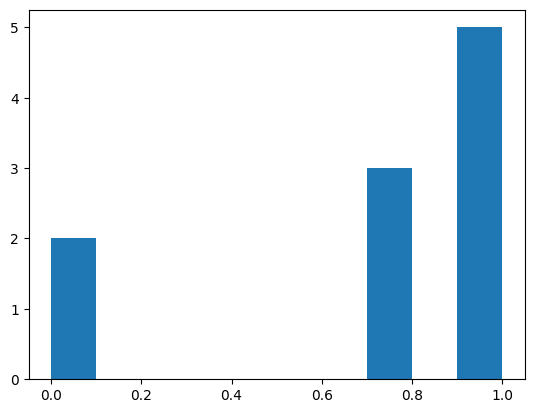

In [96]:
import matplotlib.pyplot as plt
plt.hist(result.eval_score_gpt4)